# Variational Inference example

The basic principle of using variational inference to estimate a target distribution $p(x)$: 
1. Pick surrogate distribution $q_\phi(x)$
2. Optimize the Kullback Leibler divergence: $\min\limits_\phi D_{\rm KL}(q_\phi \parallel p)$

In this notebook, we'll make use of `jax` (https://github.com/jax-ml/jax), which can automatically differentiate native Python and NumPy  functions, to simplify the optimization in step 2. 

In [1]:
import jax
import jax.numpy as jnp
from typing import NamedTuple
import optax

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# set random key for reproducibility
key = jax.random.key(0)

## Example 0
Let's start with a very simple 1D example for illustration. 

Let's say our target distribution is a simple Guassian with some arbitrary mean $\mu_0 = 1.7$ and standard deviation $\sigma_0 = 0.6$: 
$$ p(x) = \mathcal{N}(\mu_0, \sigma_0)$$

In [4]:
m0 = 1.7
s0 = 0.6

def log_p(x):
    # evaluate log of the target distribution p(x)
    return -0.5*(jnp.log(2*jnp.pi*s0**2) + (x - m0)**2 / s0**2)

### Step 1
For this example, lets use a correct surrogate distribution: 
$$q_\phi(x) = \mathcal{N}(\mu_\phi, \sigma_\phi)$$

In this case, $\phi = [\mu_\phi, \sigma_\phi]$

In [5]:
def log_q(x, mu_phi, sigma_phi):
    return -0.5*(jnp.log(2*jnp.pi*sigma_phi**2) + (x - mu_phi)**2 / sigma_phi**2)

### Step 2
We want to minimize the KL divergence: 
$$\min\limits_\phi D_{\rm KL}(q_\phi \parallel p) = \min\limits_\phi \int{\rm d}x~q_\phi(x)~\log \frac{q_\phi(x)}{p(x)}$$

Recall from the lecture that we can approximate $D_{\rm KL}$ using MC integration as: 
$$D_{\rm KL}(q_\phi \parallel p) \approx \sum\limits_{x'\sim q_\phi(x)} \left[ \log q_\phi(x') - \log p(x)\right]$$

which means we'll need a way to sample $x'\sim q_\phi(x)$

In [6]:
def sample_q(mu, rho, key, S=1):
    eps = jax.random.normal(key, (S,))
    
    sigma = softplus(rho) # this ensures that sigma is not negative
    
    return mu + sigma * eps, sigma

def softplus(x):
    return jnp.log1p(jnp.exp(-jnp.abs(x))) + jnp.maximum(x, 0.0)

In [12]:
class Params(NamedTuple):
    mu:  jnp.ndarray
    rho: jnp.ndarray

def KL(param: Params, key, S=64):
    # KL divergence D_KL(q || p) = sum log q(x) - log p(x) for x ~ q(x)

    # drawn S samples from q
    xs, sigma = sample_q(param.mu, param.rho, key, S)

    # estimate KL
    return jnp.mean(log_q(xs, param.mu, sigma) - log_p(xs))

def loss_fn(params, key):
    return KL(params, key, S=64)

@jax.jit
def step(params, opt_state, key):
    # optimization step
    key, subkey = jax.random.split(key)
    loss, grads = jax.value_and_grad(loss_fn)(params, subkey)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, key, loss    

In [13]:
# initialize the optimizer
params = Params(mu=jnp.array(0.0), rho=jnp.array(-1.0))  # mu, rho
opt = optax.adam(0.02)
opt_state = opt.init(params)

(-1.0, 4.0)

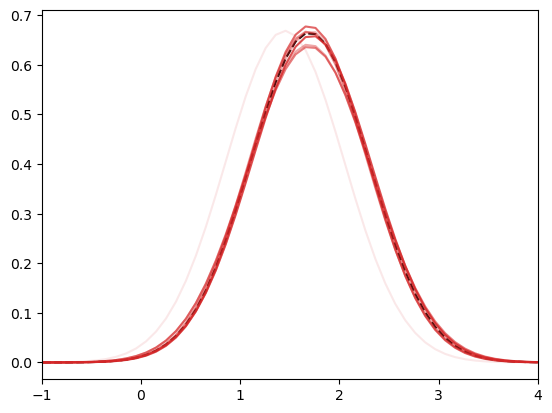

In [14]:
plt.plot(np.linspace(-10, 10, 200), np.exp(log_p(np.linspace(-10, 10, 200))), c='k', ls='--')
# ----- Train -----
# ----- Train -----
for t in range(1, 801):
    params, opt_state, key, loss = step(params, opt_state, key)
    if t % 100 == 0:
        sigma = jax.nn.softplus(params.rho)
        #print(f"iter {t:4d} | KL={loss:.6f} | mu={params.mu:.3f}  sigma={sigma:.3f}")
        plt.plot(np.linspace(-10, 10, 200), np.exp(log_q(np.linspace(-10, 10, 200), params.mu, sigma)), 
                 c='C3', alpha=np.min([0.001*float(t), 1.]))
plt.xlim(-1., 4)

In [16]:
# ----- Results -----
sigma = jax.nn.softplus(params.rho)
print("\nFinal variational params:")
print(f"mu={params.mu:.6f}  sigma={sigma:.6f}   (target: m0={m0:.6f}, s0={s0:.6f})")


Final variational params:
mu=1.717662  sigma=0.605546   (target: m0=1.700000, s0=0.600000)
